# 图像分类

在此项目中，你将对 [CIFAR-10 数据集](https://www.cs.toronto.edu/~kriz/cifar.html) 中的图片进行分类。该数据集包含飞机、猫狗和其他物体。你需要预处理这些图片，然后用所有样本训练一个卷积神经网络。图片需要标准化（normalized），标签需要采用 one-hot 编码。你需要应用所学的知识构建卷积的、最大池化（max pooling）、丢弃（dropout）和完全连接（fully connected）的层。最后，你需要在样本图片上看到神经网络的预测结果。


## 获取数据

请运行以下单元，以下载 [CIFAR-10 数据集（Python版）](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz)。


In [2]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm
import problem_unittests as tests
import tarfile

cifar10_dataset_folder_path = 'cifar-10-batches-py'

# Use Floyd's cifar-10 dataset if present
floyd_cifar10_location = '/input/cifar-10/python.tar.gz'
if isfile(floyd_cifar10_location):
    tar_gz_path = floyd_cifar10_location
else:
    tar_gz_path = 'cifar-10-python.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='CIFAR-10 Dataset') as pbar:
        urlretrieve(
            'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
            tar_gz_path,
            pbar.hook)

if not isdir(cifar10_dataset_folder_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall()
        tar.close()


tests.test_folder_path(cifar10_dataset_folder_path)

All files found!


## 探索数据

该数据集分成了几部分／批次（batches），以免你的机器在计算时内存不足。CIFAR-10 数据集包含 5 个部分，名称分别为 `data_batch_1`、`data_batch_2`，以此类推。每个部分都包含以下某个类别的标签和图片：

* 飞机
* 汽车
* 鸟类
* 猫
* 鹿
* 狗
* 青蛙
* 马
* 船只
* 卡车

了解数据集也是对数据进行预测的必经步骤。你可以通过更改 `batch_id` 和 `sample_id` 探索下面的代码单元。`batch_id` 是数据集一个部分的 ID（1 到 5）。`sample_id` 是该部分中图片和标签对（label pair）的 ID。

问问你自己：“可能的标签有哪些？”、“图片数据的值范围是多少？”、“标签是按顺序排列，还是随机排列的？”。思考类似的问题，有助于你预处理数据，并使预测结果更准确。



Stats of batch 1:
Samples: 10000
Label Counts: {0: 1005, 1: 974, 2: 1032, 3: 1016, 4: 999, 5: 937, 6: 1030, 7: 1001, 8: 1025, 9: 981}
First 20 Labels: [6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6]

Example of Image 4:
Image - Min Value: 0 Max Value: 254
Image - Shape: (32, 32, 3)
Label - Label Id: 1 Name: automobile


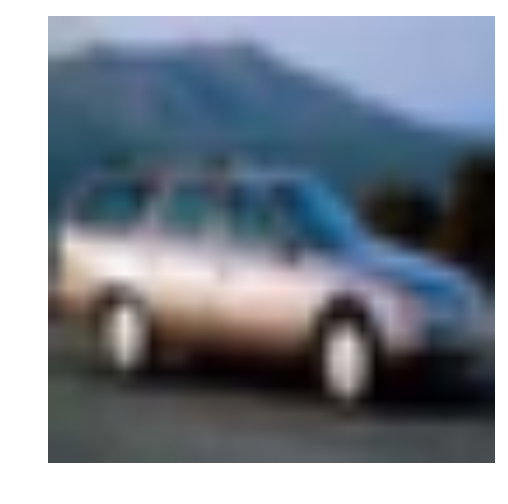

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import helper
import numpy as np

# Explore the dataset
batch_id = 1
sample_id = 4
helper.display_stats(cifar10_dataset_folder_path, batch_id, sample_id)

## 实现预处理函数

### 标准化

在下面的单元中，实现 `normalize` 函数，传入图片数据 `x`，并返回标准化 Numpy 数组。值应该在 0 到 1 的范围内（含 0 和 1）。返回对象应该和 `x` 的形状一样。


In [4]:
def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalize data
    """
    # TODO: Implement Function
    a = 0
    b = 1
    min = 0
    max = 255
    x[(x < 0)]= 0;
    x[(x > 255)]= 255;
    
    return a + ( ( (x - min)*(b - a) )/( max - min ) )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_normalize(normalize)

Tests Passed


### One-hot 编码

和之前的代码单元一样，你将为预处理实现一个函数。这次，你将实现 `one_hot_encode` 函数。输入，也就是 `x`，是一个标签列表。实现该函数，以返回为 one_hot 编码的 Numpy 数组的标签列表。标签的可能值为 0 到 9。每次调用 `one_hot_encode` 时，对于每个值，one_hot 编码函数应该返回相同的编码。确保将编码映射保存到该函数外面。

提示：不要重复发明轮子。


In [84]:
from sklearn.preprocessing import LabelBinarizer

features, labels = helper.load_cfar10_batch(cifar10_dataset_folder_path, batch_id)
encoder = LabelBinarizer()
encoder.fit(labels)
def one_hot_encode(x):
    """
    One hot encode a list of sample labels. Return a one-hot encoded vector for each label.
    : x: List of sample Labels
    : return: Numpy array of one-hot encoded labels
    """
    # TODO: Implement Function
    
    
    labels = encoder.transform(x)

    # Change to float32, so it can be multiplied against the features in TensorFlow, which are float32
    return labels.astype(np.float32)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_one_hot_encode(one_hot_encode)

Tests Passed


### 随机化数据

之前探索数据时，你已经了解到，样本的顺序是随机的。再随机化一次也不会有什么关系，但是对于这个数据集没有必要。


## 预处理所有数据并保存

运行下方的代码单元，将预处理所有 CIFAR-10 数据，并保存到文件中。下面的代码还使用了 10% 的训练数据，用来验证。


In [85]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
# Preprocess Training, Validation, and Testing Data
helper.preprocess_and_save_data(cifar10_dataset_folder_path, normalize, one_hot_encode)

# 检查点

这是你的第一个检查点。如果你什么时候决定再回到该记事本，或需要重新启动该记事本，你可以从这里开始。预处理的数据已保存到本地。


In [86]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import pickle
import problem_unittests as tests
import helper

# Load the Preprocessed Validation data
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

## 构建网络

对于该神经网络，你需要将每层都构建为一个函数。你看到的大部分代码都位于函数外面。要更全面地测试你的代码，我们需要你将每层放入一个函数中。这样使我们能够提供更好的反馈，并使用我们的统一测试检测简单的错误，然后再提交项目。

>**注意**：如果你觉得每周很难抽出足够的时间学习这门课程，我们为此项目提供了一个小捷径。对于接下来的几个问题，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 程序包中的类来构建每个层级，但是“卷积和最大池化层级”部分的层级除外。TF Layers 和 Keras 及 TFLearn 层级类似，因此很容易学会。

>但是，如果你想充分利用这门课程，请尝试自己解决所有问题，不使用 TF Layers 程序包中的任何类。你依然可以使用其他程序包中的类，这些类和你在 TF Layers 中的类名称是一样的！例如，你可以使用 TF Neural Network 版本的 `conv2d` 类 [tf.nn.conv2d](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d)，而不是 TF Layers 版本的 `conv2d` 类 [tf.layers.conv2d](https://www.tensorflow.org/api_docs/python/tf/layers/conv2d)。

我们开始吧！


### 输入

神经网络需要读取图片数据、one-hot 编码标签和丢弃保留概率（dropout keep probability）。请实现以下函数：

* 实现 `neural_net_image_input`
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * 使用 `image_shape` 设置形状，部分大小设为 `None`
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 TensorFlow `name` 参数对 TensorFlow 占位符 "x" 命名
* 实现 `neural_net_label_input`
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)
 * 使用 `n_classes` 设置形状，部分大小设为 `None`
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 TensorFlow `name` 参数对 TensorFlow 占位符 "y" 命名
* 实现 `neural_net_keep_prob_input`
 * 返回 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)，用于丢弃保留概率
 * 使用 [TF Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder) 中的 TensorFlow `name` 参数对 TensorFlow 占位符 "keep_prob" 命名

这些名称将在项目结束时，用于加载保存的模型。

注意：TensorFlow 中的 `None` 表示形状可以是动态大小。

In [6]:
import tensorflow as tf

def neural_net_image_input(image_shape):
    """
    Return a Tensor for a batch of image input
    : image_shape: Shape of the images
    : return: Tensor for image input.
    """
    # TODO: Implement Function
    print (image_shape)
    return tf.placeholder(tf.float32, shape=[None, *image_shape], name = 'x')


def neural_net_label_input(n_classes):
    """
    Return a Tensor for a batch of label input
    : n_classes: Number of classes
    : return: Tensor for label input.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, [None, n_classes], name = 'y')


def neural_net_keep_prob_input():
    """
    Return a Tensor for keep probability
    : return: Tensor for keep probability.
    """
    # TODO: Implement Function
    return tf.placeholder(tf.float32, name = 'keep_prob')


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tf.reset_default_graph()
tests.test_nn_image_inputs(neural_net_image_input)
tests.test_nn_label_inputs(neural_net_label_input)
tests.test_nn_keep_prob_inputs(neural_net_keep_prob_input)

(32, 32, 3)
Image Input Tests Passed.
Label Input Tests Passed.
Keep Prob Tests Passed.


### 卷积和最大池化层

卷积层级适合处理图片。对于此代码单元，你应该实现函数 `conv2d_maxpool` 以便应用卷积然后进行最大池化：

* 使用 `conv_ksize`、`conv_num_outputs` 和 `x_tensor` 的形状创建权重（weight）和偏置（bias）。
* 使用权重和 `conv_strides` 对 `x_tensor` 应用卷积。
 * 建议使用我们建议的间距（padding），当然也可以使用任何其他间距。
* 添加偏置
* 向卷积中添加非线性激活（nonlinear activation）
* 使用 `pool_ksize` 和 `pool_strides` 应用最大池化
 * 建议使用我们建议的间距（padding），当然也可以使用任何其他间距。

**注意**：对于**此层**，**请勿使用** [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers)，但是仍然可以使用 TensorFlow 的 [Neural Network](https://www.tensorflow.org/api_docs/python/tf/nn) 包。对于所有**其他层**，你依然可以使用快捷方法。


In [7]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    """
    Apply convolution then max pooling to x_tensor
    :param x_tensor: TensorFlow Tensor
    :param conv_num_outputs: Number of outputs for the convolutional layer
    :param conv_ksize: kernal size 2-D Tuple for the convolutional layer
    :param conv_strides: Stride 2-D Tuple for convolution
    :param pool_ksize: kernal size 2-D Tuple for pool
    :param pool_strides: Stride 2-D Tuple for pool
    : return: A tensor that represents convolution and max pooling of x_tensor
    """
    # TODO: Implement Function
    inputChanel = x_tensor.get_shape().as_list()[3]
    W = tf.Variable(tf.truncated_normal([conv_ksize[0], conv_ksize[1], inputChanel, conv_num_outputs], stddev = 0.05))
    B = tf.Variable(tf.zeros([conv_num_outputs]))
    conv = tf.nn.conv2d(x_tensor, W, strides =[1,conv_strides[0],conv_strides[1],1], padding='SAME')
    conv = tf.nn.bias_add(conv, B)
    conv = tf.nn.relu(conv)
    conv = tf.nn.max_pool(
        conv,
        ksize=[1, pool_ksize[0], pool_ksize[1], 1],
        strides=[1, pool_strides[0], pool_strides[1], 1],
        padding='SAME')
    return conv 


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_con_pool(conv2d_maxpool)

(?, 4, 4, 10)
Tests Passed


### 扁平化层

实现 `flatten` 函数，将 `x_tensor` 的维度从四维张量（4-D tensor）变成二维张量。输出应该是形状（*部分大小（Batch Size）*，*扁平化图片大小（Flattened Image Size）*）。快捷方法：对于此层，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的类。如果你想要更大挑战，可以仅使用其他 TensorFlow 程序包。


In [8]:
def flatten(x_tensor):
    """
    Flatten x_tensor to (Batch Size, Flattened Image Size)
    : x_tensor: A tensor of size (Batch Size, ...), where ... are the image dimensions.
    : return: A tensor of size (Batch Size, Flattened Image Size).
    """
    # TODO: Implement Function
    return tf.reshape(x_tensor, [-1, x_tensor.get_shape().as_list()[1] * x_tensor.get_shape().as_list()[2] * x_tensor.get_shape().as_list()[3]])


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_flatten(flatten)

Tests Passed


### 全连接层

实现 `fully_conn` 函数，以向 `x_tensor` 应用完全连接的层级，形状为（*部分大小（Batch Size）*，*num_outputs*）。快捷方法：对于此层，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的类。如果你想要更大挑战，可以仅使用其他 TensorFlow 程序包。

In [9]:
def fully_conn(x_tensor, num_outputs):
    """
    Apply a fully connected layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    print(x_tensor.get_shape())
    weight = tf.Variable(tf.random_normal([x_tensor.get_shape().as_list()[1], num_outputs]))
    bias = tf.Variable(tf.random_normal([num_outputs]))
    fc = tf.add(tf.matmul(x_tensor, weight), bias)
    return tf.nn.relu(fc)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_fully_conn(fully_conn)

(?, 128)
Tests Passed


### 输出层

实现 `output` 函数，向 x_tensor 应用完全连接的层级，形状为（*部分大小（Batch Size）*，*num_outputs*）。快捷方法：对于此层，你可以使用 [TensorFlow Layers](https://www.tensorflow.org/api_docs/python/tf/layers) 或 [TensorFlow Layers (contrib)](https://www.tensorflow.org/api_guides/python/contrib.layers) 包中的类。如果你想要更大挑战，可以仅使用其他 TensorFlow 程序包。

**注意**：该层级不应应用 Activation、softmax 或交叉熵（cross entropy）。

In [12]:
def output(x_tensor, num_outputs):
    """
    Apply a output layer to x_tensor using weight and bias
    : x_tensor: A 2-D tensor where the first dimension is batch size.
    : num_outputs: The number of output that the new tensor should be.
    : return: A 2-D tensor where the second dimension is num_outputs.
    """
    # TODO: Implement Function
    weight = tf.Variable(tf.random_normal([x_tensor.get_shape().as_list()[1], num_outputs]))
    bias = tf.Variable(tf.random_normal([num_outputs]))
    return tf.add(tf.matmul(x_tensor, weight), bias)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_output(output)

Tests Passed


### 创建卷积模型

实现函数 `conv_net`， 创建卷积神经网络模型。该函数传入一批图片 `x`，并输出对数（logits）。使用你在上方创建的层创建此模型：

* 应用 1、2 或 3 个卷积和最大池化层（Convolution and Max Pool layers）
* 应用一个扁平层（Flatten Layer）
* 应用 1、2 或 3 个完全连接层（Fully Connected Layers）
* 应用一个输出层（Output Layer）
* 返回输出
* 使用 `keep_prob` 向模型中的一个或多个层应用 [TensorFlow 的 Dropout](https://www.tensorflow.org/api_docs/python/tf/nn/dropout)

In [13]:
def conv_net(x, keep_prob):
    """
    Create a convolutional neural network model
    : x: Placeholder tensor that holds image data.
    : keep_prob: Placeholder tensor that hold dropout keep probability.
    : return: Tensor that represents logits
    """
    # TODO: Apply 1, 2, or 3 Convolution and Max Pool layers
    #    Play around with different number of outputs, kernel size and stride
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
    
    
    conv_1 = conv2d_maxpool(x, 128, (3,3), (1,1), (2,2), (2,2))
    conv_2 = conv2d_maxpool(conv_1, 256, (1,1), (1,1), (2,2), (2,2))
    conv_3 = conv2d_maxpool(conv_2, 384, (9,9), (1,1), (2,2), (2,2))
    
    conv_4 = conv2d_maxpool(conv_3, 512, (1,1), (1,1), (2,2), (2,2))

    # TODO: Apply a Flatten Layer
    # Function Definition from Above:
    #   flatten(x_tensor)
    fl = flatten(conv_4)

    # TODO: Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    #   fully_conn(x_tensor, num_outputs)
    fc_1 = fully_conn(fl, 1024)
   # fc_2 = fully_conn(fc_1, 512)
   # fc_3 = fully_conn(fc_2, 256)
    
    dr = tf.nn.dropout(fc_1, keep_prob)
    # TODO: Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    #   output(x_tensor, num_outputs)
    out = output(dr, 10)
    
    # TODO: return output
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

##############################
## Build the Neural Network ##
##############################

# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((32, 32, 3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)

# Name logits Tensor, so that is can be loaded from disk after training
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

tests.test_conv_net(conv_net)

(32, 32, 3)
(?, 2048)
(?, 2048)
Neural Network Built!


## 训练神经网络

### 单次优化

实现函数 `train_neural_network` 以进行单次优化（single optimization）。该优化应该使用 `optimizer` 优化 `session`，其中 `feed_dict` 具有以下参数：

* `x` 表示图片输入
* `y` 表示标签
* `keep_prob` 表示丢弃的保留率

每个部分都会调用该函数，所以 `tf.global_variables_initializer()` 已经被调用。

注意：不需要返回任何内容。该函数只是用来优化神经网络。


In [109]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    """
    Optimize the session on a batch of images and labels
    : session: Current TensorFlow session
    : optimizer: TensorFlow optimizer function
    : keep_probability: keep probability
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    """
    # TODO: Implement Function
    session.run(optimizer, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: keep_probability})


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_train_nn(train_neural_network)

Tests Passed


### 显示数据

实现函数 `print_stats` 以输出损失和验证准确率。使用全局变量 `valid_features` 和 `valid_labels` 计算验证准确率。使用保留率 `1.0` 计算损失和验证准确率（loss and validation accuracy）。


In [10]:
def print_stats(session, feature_batch, label_batch, cost, accuracy,keep_probability):
    """
    Print information about loss and validation accuracy
    : session: Current TensorFlow session
    : feature_batch: Batch of Numpy image data
    : label_batch: Batch of Numpy label data
    : cost: TensorFlow cost function
    : accuracy: TensorFlow accuracy function
    """
    loss = session.run(cost, feed_dict={
                x: feature_batch,
                y: label_batch,
                keep_prob: 1
                })
    valid_acc = session.run(accuracy, feed_dict={
                x: valid_features,
                y: valid_labels,
                keep_prob: 1
                })

    print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(
                loss,
                valid_acc))
    

### 超参数

调试以下超参数：
* 设置 `epochs` 表示神经网络停止学习或开始过拟合的迭代次数
* 设置 `batch_size`，表示机器内存允许的部分最大体积。大部分人设为以下常见内存大小：

 * 64
 * 128
 * 256
 * ...
* 设置 `keep_probability` 表示使用丢弃时保留节点的概率

In [118]:
# TODO: Tune Parameters
epochs = 60
batch_size = 128
keep_probability = 0.6

### 在单个 CIFAR-10 部分上训练

我们先用单个部分，而不是用所有的 CIFAR-10 批次训练神经网络。这样可以节省时间，并对模型进行迭代，以提高准确率。最终验证准确率达到 50% 或以上之后，在下一部分对所有数据运行模型。


In [119]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        batch_i = 1
        for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
            train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_stats(sess, batch_features, batch_labels, cost, accuracy, keep_probability)

Checking the Training on a Single Batch...
Epoch  1, CIFAR-10 Batch 1:  Loss:    33.4278 Validation Accuracy: 0.173200
Epoch  2, CIFAR-10 Batch 1:  Loss:    18.7795 Validation Accuracy: 0.248400
Epoch  3, CIFAR-10 Batch 1:  Loss:    13.5649 Validation Accuracy: 0.297000
Epoch  4, CIFAR-10 Batch 1:  Loss:     9.4124 Validation Accuracy: 0.309400
Epoch  5, CIFAR-10 Batch 1:  Loss:     5.5260 Validation Accuracy: 0.352800
Epoch  6, CIFAR-10 Batch 1:  Loss:     2.4890 Validation Accuracy: 0.388400
Epoch  7, CIFAR-10 Batch 1:  Loss:     1.3587 Validation Accuracy: 0.407600
Epoch  8, CIFAR-10 Batch 1:  Loss:     1.9464 Validation Accuracy: 0.401600
Epoch  9, CIFAR-10 Batch 1:  Loss:     2.3062 Validation Accuracy: 0.436800
Epoch 10, CIFAR-10 Batch 1:  Loss:     1.4610 Validation Accuracy: 0.381600
Epoch 11, CIFAR-10 Batch 1:  Loss:     1.0838 Validation Accuracy: 0.443800
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.9269 Validation Accuracy: 0.397000
Epoch 13, CIFAR-10 Batch 1:  Loss:     1.5118

### 完全训练模型

现在，单个 CIFAR-10 部分的准确率已经不错了，试试所有五个部分吧。

In [120]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
save_model_path = './image_classification'

print('Training...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    
    # Training cycle
    for epoch in range(epochs):
        # Loop over all batches
        n_batches = 5
        for batch_i in range(1, n_batches + 1):
            for batch_features, batch_labels in helper.load_preprocess_training_batch(batch_i, batch_size):
                train_neural_network(sess, optimizer, keep_probability, batch_features, batch_labels)
            print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
            print_stats(sess, batch_features, batch_labels, cost, accuracy, keep_probability)
            
    # Save Model
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training...
Epoch  1, CIFAR-10 Batch 1:  Loss:    26.5099 Validation Accuracy: 0.180600
Epoch  1, CIFAR-10 Batch 2:  Loss:    22.7058 Validation Accuracy: 0.260000
Epoch  1, CIFAR-10 Batch 3:  Loss:     8.1044 Validation Accuracy: 0.323200
Epoch  1, CIFAR-10 Batch 4:  Loss:     5.3947 Validation Accuracy: 0.352800
Epoch  1, CIFAR-10 Batch 5:  Loss:     4.5609 Validation Accuracy: 0.376600
Epoch  2, CIFAR-10 Batch 1:  Loss:     4.7394 Validation Accuracy: 0.355600
Epoch  2, CIFAR-10 Batch 2:  Loss:     3.6566 Validation Accuracy: 0.351600
Epoch  2, CIFAR-10 Batch 3:  Loss:     2.0207 Validation Accuracy: 0.442000
Epoch  2, CIFAR-10 Batch 4:  Loss:     2.8482 Validation Accuracy: 0.357800
Epoch  2, CIFAR-10 Batch 5:  Loss:     2.1122 Validation Accuracy: 0.448400
Epoch  3, CIFAR-10 Batch 1:  Loss:     2.4100 Validation Accuracy: 0.407400
Epoch  3, CIFAR-10 Batch 2:  Loss:     1.9656 Validation Accuracy: 0.435000
Epoch  3, CIFAR-10 Batch 3:  Loss:     1.2787 Validation Accuracy: 0.455000


Epoch 22, CIFAR-10 Batch 4:  Loss:     0.2287 Validation Accuracy: 0.638800
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.1804 Validation Accuracy: 0.595600
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.0844 Validation Accuracy: 0.620200
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.0729 Validation Accuracy: 0.627400
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.0395 Validation Accuracy: 0.634200
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.1962 Validation Accuracy: 0.628000
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.0953 Validation Accuracy: 0.592400
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.3341 Validation Accuracy: 0.598400
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.0701 Validation Accuracy: 0.644600
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.2804 Validation Accuracy: 0.599600
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.1638 Validation Accuracy: 0.629000
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.1845 Validation Accuracy: 0.605400
Epoch 25, CIFAR-10 Batch 1:  Loss:     0.0441 Validation Accuracy: 0.632800
Epoch 25, CI

Epoch 44, CIFAR-10 Batch 2:  Loss:     0.0028 Validation Accuracy: 0.664200
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.0937 Validation Accuracy: 0.651400
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.0002 Validation Accuracy: 0.655200
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.0053 Validation Accuracy: 0.630800
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.0024 Validation Accuracy: 0.660600
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.0278 Validation Accuracy: 0.648200
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.2444 Validation Accuracy: 0.647200
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.1067 Validation Accuracy: 0.647800
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.0070 Validation Accuracy: 0.682400
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.1417 Validation Accuracy: 0.669000
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.0986 Validation Accuracy: 0.645600
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.0025 Validation Accuracy: 0.666800
Epoch 46, CIFAR-10 Batch 4:  Loss:     0.1114 Validation Accuracy: 0.654400
Epoch 46, CI

# 检查点

模型已保存到本地。

## 测试模型

利用测试数据集测试你的模型。这将是最终的准确率。你的准确率应该高于 50%。如果没达到，请继续调整模型结构和参数。

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.686807753164557



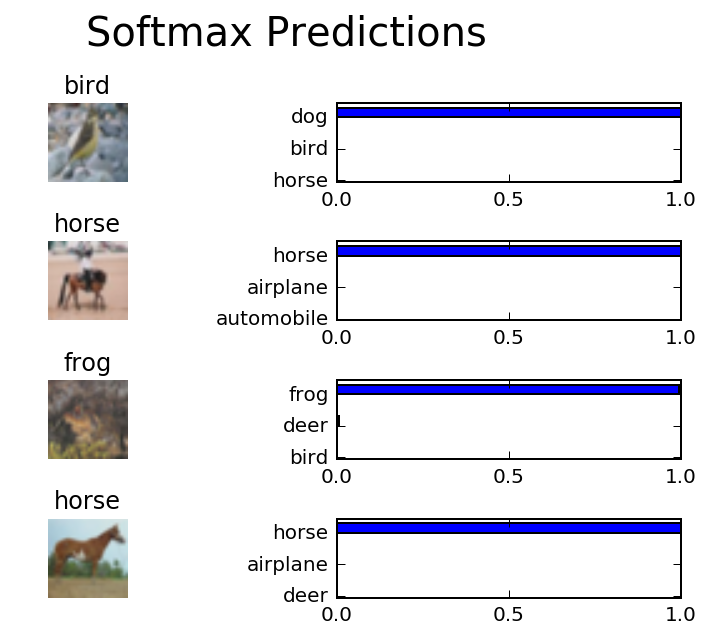

In [121]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import tensorflow as tf
import pickle
import helper
import random

# Set batch size if not already set
try:
    if batch_size:
        pass
except NameError:
    batch_size = 64

save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
    """
    Test the saved model against the test dataset
    """

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')
        
        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0
        
        for test_feature_batch, test_label_batch in helper.batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        helper.display_image_predictions(random_test_features, random_test_labels, random_test_predictions)


test_model()


### 为何准确率只有50-80%？

你可能想问，为何准确率不能更高了？首先，对于简单的 CNN 网络来说，50% 已经不低了。纯粹猜测的准确率为10%。但是，你可能注意到有人的准确率[远远超过 80%](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130)。这是因为我们还没有介绍所有的神经网络知识。我们还需要掌握一些其他技巧。

## 提交项目

提交项目时，确保先运行所有单元，然后再保存记事本。将 notebook 文件另存为“dlnd_image_classification.ipynb”，再在目录 "File" -> "Download as" 另存为 HTML 格式。请在提交的项目中包含 “helper.py” 和 “problem_unittests.py” 文件。
